In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [2]:
here = Path.cwd()
root = next(p for p in [here, *here.parents] if (p / "data" / "processed").exists())

#creating 2 columns to identify source file and if ios or android
df_v3 = pd.read_csv(root / "data" / "processed" / "merged" / "state1_clean.csv", header=0)
df_v3.head() 

,is_ios,source_file,eventType,eventSampleSpeed,eventDurationSeconds,eventMilesDriven,eventSensorDetectionMthd,eventGPSSignalStrength,eventStartSpeed,eventEndSpeed,memsMedianHorizontalNorm,gyro_angular_change_per_second,gyroAngleChange,mems_radius
0,0,android_turns.csv,5.0,12.743101,3.173500,0.007654,1,15.306123,10.714942,13.421639,3.099853,17.929585,57.610783,23.959110
1,0,android_turns.csv,5.0,11.281634,2.737719,0.008573,1,19.387754,9.529365,10.491248,1.173136,11.777087,32.709633,9.324203
2,0,android_turns.csv,5.0,11.028114,3.967555,0.009012,1,16.836735,8.478003,14.696693,2.366215,22.094933,88.539480,3.087557
3,0,android_turns.csv,4.0,19.864027,5.356430,0.025984,1,20.663265,22.033857,18.588970,2.522688,16.592813,89.536600,12.669695
4,0,android_turns.csv,5.0,16.620464,5.078434,0.019170,1,19.387754,19.640330,18.141582,2.252747,18.612541,95.261020,10.121602


In [3]:
df_v3.drop(columns=['source_file'], inplace=True)

sub_df_left = df_v3[df_v3['eventType'] == 4]
sub_df_left = sub_df_left.drop(columns=['is_ios', 'eventType', 'eventSampleSpeed', 'eventSensorDetectionMthd', 'eventGPSSignalStrength'])

In [4]:
sub_df_left.columns.tolist()

['eventDurationSeconds',
 'eventMilesDriven',
 'eventStartSpeed',
 'eventEndSpeed',
 'memsMedianHorizontalNorm',
 'gyro_angular_change_per_second',
 'gyroAngleChange',
 'mems_radius']

In [5]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
scaler =StandardScaler()

X_features = sub_df_left
features = scaler.fit_transform(X_features)
scaled_df = pd.DataFrame(features,columns=X_features.columns)

# Print the scaled data
X = scaled_df.values
scaled_df.head(2)


,eventDurationSeconds,eventMilesDriven,eventStartSpeed,eventEndSpeed,memsMedianHorizontalNorm,gyro_angular_change_per_second,gyroAngleChange,mems_radius
0,-0.179768,0.159622,1.008019,0.164724,0.585077,0.490885,0.277069,-0.307387
1,-1.244080,-1.286727,-1.279475,-1.301272,1.421853,3.089724,0.049345,-0.432527


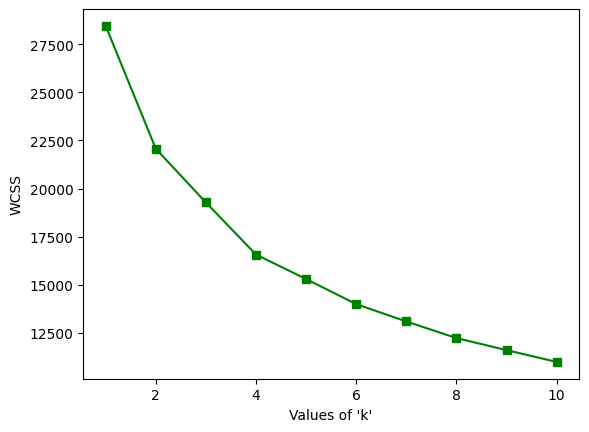

In [6]:
wcss = {} 
for i in range(1, 11): 
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X) 
    wcss[i] = kmeans.inertia_
    
plt.plot(wcss.keys(), wcss.values(), 'gs-')
plt.xlabel("Values of 'k'")
plt.ylabel('WCSS')
plt.show()

In [7]:
results = []

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(features)

    sil = silhouette_score(features, labels)
    ch = calinski_harabasz_score(features, labels)

    results.append((k, sil, ch))

for r in results:
    print(f"k={r[0]} | Silhouette={r[1]:.3f} | CH Score={r[2]:.0f}")

k=2 | Silhouette=0.286 | CH Score=1027
k=3 | Silhouette=0.278 | CH Score=845
k=4 | Silhouette=0.187 | CH Score=848
k=5 | Silhouette=0.191 | CH Score=763
k=6 | Silhouette=0.191 | CH Score=733
k=7 | Silhouette=0.182 | CH Score=693
k=8 | Silhouette=0.177 | CH Score=672
k=9 | Silhouette=0.167 | CH Score=643


In [8]:
kmeans=KMeans(n_clusters=5)
kmeans.fit(X)
sub_df_left['cluster'] = kmeans.fit_predict(X)

In [9]:
pca=PCA(n_components=2)

reduced_X=pd.DataFrame(data=pca.fit_transform(X),columns=['PCA1','PCA2'])

#Reduced Features
reduced_X.head()

,PCA1,PCA2
0,0.045693,-0.205752
1,-3.717065,-0.338781
2,-1.522916,0.548569
3,-0.414212,-0.460973
4,-0.862435,0.433359


In [10]:
centers=pca.transform(kmeans.cluster_centers_)

# reduced centers
centers

array([[ 0.85022881,  0.25179295],
       [ 2.75950383, -1.60211768],
       [-1.00198024, -0.27172884],
       [-1.01162413, -0.02315192],
       [ 2.04474441,  3.66468256]])

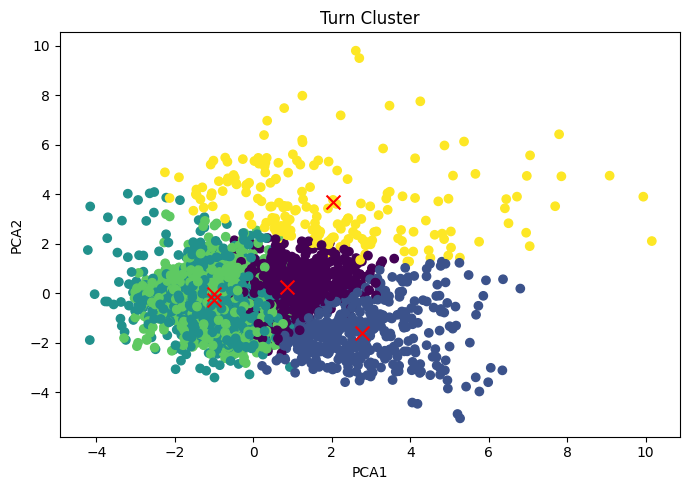

In [11]:
plt.figure(figsize=(7,5))

# Scatter plot
plt.scatter(reduced_X['PCA1'],reduced_X['PCA2'],c=kmeans.labels_)
plt.scatter(centers[:,0],centers[:,1],marker='x',s=100,c='red')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Turn Cluster')
plt.tight_layout()

In [12]:
sub_df_left.groupby('cluster').mean(numeric_only=True).T

cluster,0,1,2,3,4
eventDurationSeconds,6.698738,5.460487,4.698744,5.029516,12.142222
eventMilesDriven,0.030499,0.035664,0.019004,0.013739,0.052545
eventStartSpeed,12.367033,27.391548,14.003122,9.014218,14.368344
eventEndSpeed,20.115765,28.441478,17.662733,11.818987,16.297739
memsMedianHorizontalNorm,2.033842,1.912385,2.872465,1.539876,1.347300
gyro_angular_change_per_second,12.600901,9.019760,18.665717,14.615655,12.419867
gyroAngleChange,83.593509,49.130621,88.252604,73.129321,146.831215
mems_radius,23.009616,33.962849,10.269641,11.937832,19.027565


In [13]:
kmeans=KMeans(n_clusters=7)
kmeans.fit(X)
sub_df_left['cluster'] = kmeans.fit_predict(X)

In [14]:
pca=PCA(n_components=2)

reduced_X=pd.DataFrame(data=pca.fit_transform(X),columns=['PCA1','PCA2'])

#Reduced Features
reduced_X.head()

,PCA1,PCA2
0,0.045693,-0.205752
1,-3.717065,-0.338781
2,-1.522916,0.548569
3,-0.414212,-0.460973
4,-0.862435,0.433359


In [15]:
centers=pca.transform(kmeans.cluster_centers_)

# reduced centers
centers

array([[-0.31642994, -0.50673669],
       [-1.6774461 ,  0.02110997],
       [ 2.66368455, -1.81045975],
       [-0.68562596, -0.06913   ],
       [ 1.14117097,  0.53622173],
       [ 4.61123534,  2.53739471],
       [-0.20321186,  3.86092044]])

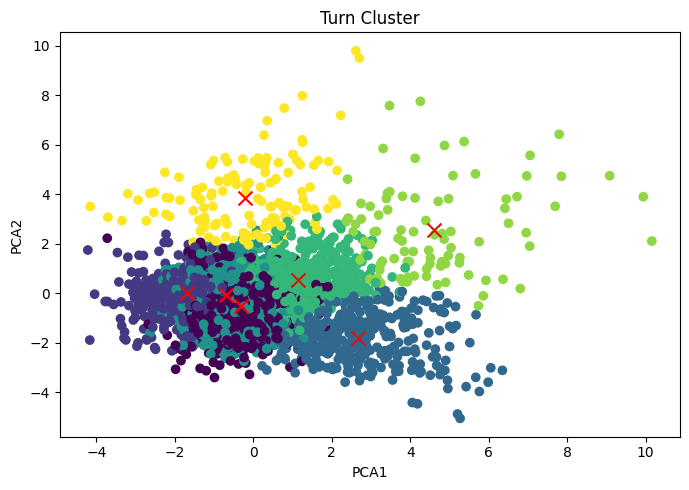

In [16]:
plt.figure(figsize=(7,5))

# Scatter plot
plt.scatter(reduced_X['PCA1'],reduced_X['PCA2'],c=kmeans.labels_)
plt.scatter(centers[:,0],centers[:,1],marker='x',s=100,c='red')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Turn Cluster')
plt.tight_layout()

In [17]:
sub_df_left.groupby('cluster').mean(numeric_only=True).T

cluster,0,1,2,3,4,5,6
eventDurationSeconds,4.916082,4.514219,5.129011,5.250829,7.344112,12.214999,10.486221
eventMilesDriven,0.022592,0.013948,0.033306,0.014541,0.032799,0.077773,0.032981
eventStartSpeed,17.406460,7.027317,27.407316,10.081789,11.244807,24.025495,10.614732
eventEndSpeed,19.609650,14.002409,28.521825,11.718491,20.125331,26.591239,11.099664
memsMedianHorizontalNorm,2.902698,2.245436,1.946109,1.389501,1.857888,1.490309,1.638117
gyro_angular_change_per_second,16.745134,18.910831,9.008509,13.203651,11.827107,9.166298,17.248820
gyroAngleChange,82.716142,84.841463,46.270343,69.553246,85.669126,111.554038,172.580321
mems_radius,12.346069,9.358273,34.633386,13.832446,25.600656,29.843490,8.291531


In [18]:
kmeans=KMeans(n_clusters=3)
kmeans.fit(X)
sub_df_left['cluster'] = kmeans.fit_predict(X)

In [19]:
pca=PCA(n_components=2)

reduced_X=pd.DataFrame(data=pca.fit_transform(X),columns=['PCA1','PCA2'])

#Reduced Features
reduced_X.head()

,PCA1,PCA2
0,0.045693,-0.205752
1,-3.717065,-0.338781
2,-1.522916,0.548569
3,-0.414212,-0.460973
4,-0.862435,0.433359


In [20]:
centers=pca.transform(kmeans.cluster_centers_)

# reduced centers
centers

array([[ 2.48287795, -0.1985646 ],
       [-0.74578306, -0.25735476],
       [-0.64730994,  0.3680812 ]])

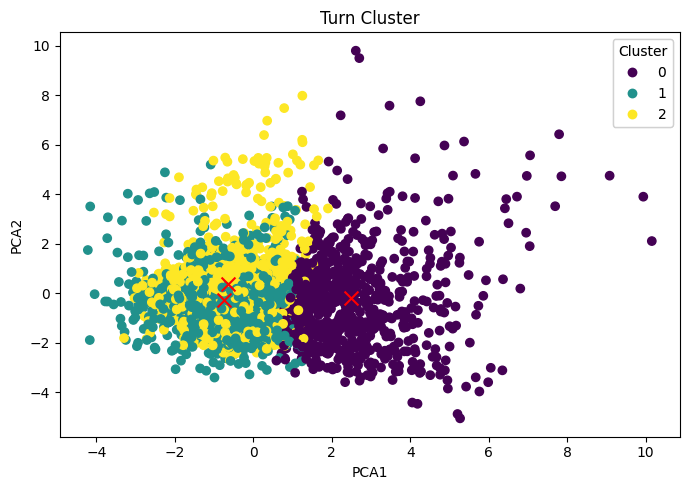

In [21]:
plt.figure(figsize=(7,5))
scatter = plt.scatter(
    reduced_X['PCA1'], reduced_X['PCA2'],
    c=kmeans.labels_, cmap='viridis'
)
plt.scatter(centers[:,0], centers[:,1], marker='x', s=100, c='red')

# Add legend showing which color corresponds to which cluster
legend = plt.legend(
    *scatter.legend_elements(),
    title="Cluster",
    loc="upper right"
)
plt.gca().add_artist(legend)

plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.title("Turn Cluster")
plt.tight_layout()
plt.show()

In [22]:
sub_df_left.groupby('cluster').mean(numeric_only=True).T

cluster,0,1,2
eventDurationSeconds,7.219486,4.875153,5.821044
eventMilesDriven,0.040726,0.020344,0.017223
eventStartSpeed,21.153324,13.749891,8.866663
eventEndSpeed,24.993745,18.115681,12.494440
memsMedianHorizontalNorm,1.875238,2.733103,1.482409
gyro_angular_change_per_second,10.022542,17.670038,13.970461
gyroAngleChange,72.899247,86.169562,80.826904
mems_radius,31.640055,11.779682,13.559723
